- 回帰分析の改良
- バスケット分析(どの商品が一緒に購入されたか)による推薦システム

# まとめ
- 映画の推薦システムの改良
    - スコアではなく，どの映画にスコアをつけたかに注目
        - スコアをつけた映画が似ているユーザのスコアを予測値とする手法
            - 各ユーザの相関係数を利用する
        - 逆に，スコアをつけたユーザが似ている映画に着目してみる手法
    - アンサンブル学習: 上記の2つの手法のような，複数の手法を組み合わせて予測を行う手法
        - 各手法の予測結果は新たな特徴量と考えられるので，回帰によって重み付けを行える．
            - 重み付けの結果，重みの小さな特徴量は役に立たず，全体のパフォーマンスを下げる可能性もある．
            - 複数の手法を簡単に比較検討する手段としても使える．
- バスケット分析: 「この商品を買った人はこんな商品も買っています」
    - どの商品が一緒に買われているかに着目する．
        - あるユーザが複数の商品を買っている時，そのユーザが他にどんなものを買う傾向があるのかを予測できる．  
        - 生活必需品など，多くの人が買わざるを得ない商品はユーザの趣味嗜好に関係がないので注意する．
    - ベルギーのスーパーマーケットでの匿名トランザクションデータ, retail.datを使って実験
    - 1. 頻出アイテム集合の列挙
        - アプリオリアルゴリズム: 頻出アイテム集合: 頻繁に購入される商品の組み合わせ をトランザクション集合から列挙する．
            - 購入頻度(支持度)が閾値(最小支持度)以上の商品1つによる集合を頻出アイテム集合とするところから始める
            - 頻出アイテム集合に一つ頻出アイテムを追加し，その支持度を求め, それがまだ最小支持度以上ならば頻出アイテム集合として記録していく
            - 新たな頻出アイテム集合がどのトランザクションに含まれているかをキャッシュすることによって高速化することができる．
    - 2. アソシエーションルールマイニング
        - 頻出アイテム集合の列挙を元に，アソシエーションルールの強さを導く
            - アソシエーションルール: 「この商品の組みあわせXを買っている人はこの商品Yを買っている傾向がある」
        - アソシエーションルールの強さの指標として，次のLIFT値を用いる. 誰もが買っている商品に対するペナルティを課している．
            $$ lift(X \Rightarrow Y) = \frac{P(Y | X)}{P(Y)} $$
        - 1で作成したキャッシュを利用することで高速化できる．
    - 他にも，買い物の順序を考慮した手法などが，pyminingというパッケージで提供されている．

# 推薦システムを改良する
前章の映画スコアデータを使った推薦システムの改良  
まずはデータの読みこみ

In [1]:
import numpy as np
from scipy import sparse # 2次元スパース行列のためのパッケージ

data = np.array([ [int(tok) for tok in line.split('\t')[:3]] for line in open('./data/ml-100k/u.data')])
ij = data[:, :2] # 誰が，どの映画を
ij -= 1  # original data is in 1-based system
values = data[:, 2] # 何点と評価したのか
reviews = sparse.csc_matrix((values, ij.T)).astype(float) # ユーザ*映画 の Compressed Sparse Column matrix 
print(reviews.shape)

(943, 1682)


## 二値行列を用いたレコメンド
Netflix Challengeで興味深かったことは，スコアを知らなくても，どの映画に点数をつけたかで大体の予測がつくということ．  
点数を可視化してみる．

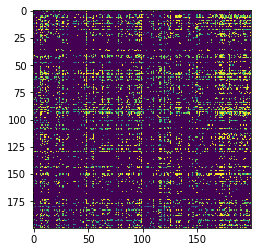

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

imagedata = reviews[:200, :200].todense() # 疎行列形式から通常の行列に戻す
plt.imshow(imagedata, interpolation='nearest') # interpolation: 補完．小数だったりする値を近い方の整数値に寄せる

映画のスコア予測のために，二値行列を利用する．  
1. 各ユーザごとに他のユーザを2値ベクトルの相関係数順にランク付けする．
2. 対象の映画に点数をつけている何人かの類似ユーザのスコアを参考に，スコアを予測する．  

In [2]:
def all_correlations(bait, target):
    '''
    corrs = all_correlations(bait, target)
    corrs[i] はbaitとtarget[i]の相関係数
    '''
    return np.array([np.corrcoef(bait, c)[0, 1] for c in target])

In [3]:
# 定義式に沿って計算した方が早いらしい
def all_correlations(y, X):
    '''
    Cs = all_correlations(y, X)

    Cs[i] = np.corrcoef(y, X[i])[0,1]
    '''
    X = np.asanyarray(X, float)
    y = np.asanyarray(y, float)
    xy = np.dot(X, y)
    y_ = y.mean()
    ys_ = y.std()
    x_ = X.mean(1)
    xs_ = X.std(1)
    n = float(len(y))
    ys_ += 1e-5  # Handle zeros in ys
    xs_ += 1e-5  # Handle zeros in x

    return (xy - x_ * y_ * n) / n / xs_ / ys_


まずは各ユーザに近い100人のユーザの平均をとってみる

In [4]:
def estimate_user(user, rest):
    '''
    'rest' に基づいて, 'user'の映画スコアを予測する
    '''
    bu = user > 0 # userのレーティングを二値化
    br = rest > 0 # restのレーティングを二値化
    ws = all_correlations(bu, br)
    
    selected = ws.argsort()[-100:] # 相関係数の大きい順に100個インデックスを選ぶ
    estimates = rest[selected].mean(0) # 平均値を元に予測する
    
    # ある映画は他の映画より多くのユーザから点数をつけられている
    # それを考慮して，予測結果を修正する必要がある．
    estimates /= (.1 + br[selected].mean(0))
    
    return estimates

In [27]:
rmses = []
for i in range(reviews.shape[0]):
    rmse = rmse_for(i)
    rmses.append(rmse)

print(f"Average RMSE: {np.asarray(rmses).mean()}")

Average RMSE: 1.7369766471853734


In [5]:
def train_test(user, rest):
    estimates = estimate_user(user, rest)
    bu = user > 0
    br = rest > 0
    err = estimates[bu] - user[bu]
    null = rest.mean(0)
    null /= (.1 + br.mean(0))
    nerr = null[bu] - user[bu]
    return np.dot(err, err), np.dot(nerr, nerr)


def cross_validate_all(reviews):
    err = []
    reviews = reviews.toarray()
    for i in range(reviews.shape[0]):
        err.append( train_test(reviews[i], np.delete(reviews, i, 0)) )
    revs = (reviews > 0).sum(1)
    err = np.array(err)
    rmse = np.sqrt(err / revs[:, None])
    print(np.mean(rmse, 0))
    print(np.mean(rmse[revs > 60], 0))


def all_estimates_user(reviews):
    reviews = reviews.toarray()
    estimates = np.zeros_like(reviews)
    for i in range(reviews.shape[0]):
        estimates[i] = estimate_user(reviews[i], np.delete(reviews, i, 0))
    return estimates

In [14]:
cross_validate_all(reviews)

[1.44212893 1.84657472]
[1.4003051  1.86231581]


In [11]:
estimates = all_estimates_user(reviews)
estimates.shape

(943, 1682)

データセットの全ユーザを用いて予測した場合と比較すると20％良い結果らしい．  
映画の点数をつける回数の多い上位半分のユーザを対象にすると25%誤差を減らせるらしい  
誤差大きすぎ，20%も25%も何が変わっているのかわからない．意味不明

## 類似映画について考える
類似ユーザと同様に，類似映画を対象とした再近傍探索に基づく推薦システムを作成してみる  
ユーザUの映画Mに対するレーティングを予測する場合，映画Mにもっとも似ている映画と同じレーティングを結果とする．  
1. 映画の類似行列を計算(各映画に対して，どの映画がもっとも類似しているかを判定するための行列)
2. その類似行列を基に，ユーザと映画の各組み合わせについて予測を行う．

In [6]:
# 映画の類似行列を作成
def movie_likeness_matrix(reviews):
    reviews = reviews.toarray()
    nmovies = reviews.shape[1]
    movie_likeness = np.zeros( (nmovies, nmovies))
    for i in range(nmovies):
        movie_likeness[i] = all_correlations(reviews[:, i], reviews.T)
        movie_likeness[i, i] = -1 # もっとも似ている映画は自分自身であるため，類似結果が自分自身であることを防ぐ．

In [29]:
movie_likeness = movie_likeness_matrix(reviews)

In [7]:
def nn_movie(movie_likeness, reviews, uid, mid): # uid: ユーザID, mid: 映画のID
    likes = movie_likeness[mid].argsort()[::-1]
    for ell in likes:
        if reviews[uid, ell] > 0:
            return reviews[uid, ell]

In [8]:
# 平均を引いたりなんだりしたnn_movie
def nn_movie(ureviews, reviews, uid, mid, k=1):
    X = ureviews
    y = ureviews[mid].copy()
    y -= y.mean()
    y /= (y.std() + 1e-5)
    corrs = np.dot(X, y)
    likes = corrs.argsort()[::-1]
    c = 0
    pred = 3.
    for ell in likes:
        if ell == mid:
            continue
        if reviews[uid, ell] > 0:
            pred = reviews[uid, ell]
            if c == k:
                return pred
            c += 1
    return pred

In [9]:
def all_estimates_movie(reviews, k=1):
    reviews = reviews.astype(float)
    k -= 1
    nusers, nmovies = reviews.shape
    estimates = np.zeros_like(reviews)
    for u in range(nusers):
        ureviews = np.delete(reviews, u, 0)
        ureviews -= ureviews.mean(0)
        ureviews /= (ureviews.std(0) + 1e-4)
        ureviews = ureviews.T.copy()
        for m in np.where(reviews[u] > 0)[0]:
            estimates[u, m] = nn_movie(ureviews, reviews, u, m, k)
    return estimates

In [25]:
arr_reviews = reviews.toarray()
estimates = all_estimates_movie(arr_reviews)
error = (estimates - arr_reviews)
error **= 2
error = error[arr_reviews > 0]
print(np.sqrt(error).mean())

0.84539


いい結果．

## 複数の手法を組み合わせる
これまで解説した2つの手法を組み合わせて，一つの予測器を作る．  
たとえば，両予測のスコア平均をとればいいが，ちょうど半分にする理由もない．  
最適な重みをそれぞれの予測結果にかけてやる．その重みもデータから学習する．  
<br>
このように，複数の予測器の結果を組み合わせる手法をアンサンブル学習という．  
興味深い点として，各予測器を新しい特徴量として考えることができる．  
重みが大きい予測器はそのアイデアが有効であり，そうでないものは全体のパフォーマンスを下げることもある．

In [10]:
# CV設定しろっていうワーニングをとりあえず止める
import warnings
warnings.filterwarnings('ignore')

In [11]:
from utils import create_or_load_pickle
from ch08 import similar_movie, corrneighbours, usermodel
# これら3つはpython3への変換，アンサンブル学習ができるようにするための修正などを行なっている．

# es(estimates?)に複数の手法の予測結果を格納
def ensemble_results():
    return np.array([
        usermodel.all_estimates(reviews),
        corrneighbours.all_estimates(reviews),
        similar_movie.all_estimates(reviews)
    ])

ppath = "data/ch08_estimates.pkl"
es = create_or_load_pickle(ppath, ensemble_results)

data/ch08_estimates.pkl was loaded from the pickle file.


In [12]:
from sklearn.linear_model import LinearRegression

def ensemble(es, reviews):
    reviews = reviews.toarray()
    
    reg = LinearRegression()
    coefficients = []
    rmses = []
    # ホールドアウトクロスバリデーションのループを実行する．
    for u in range(reviews.shape[0]):
        es0 = np.delete(es, u, 1) # u番目のユーザを除く
        r0 = np.delete(reviews, u, 0)
        p0, p1 = np.where(r0 > 0) # 点数が付けれられている要素だけ対象とする
        X = es[:, p0, p1]
        y = r0[r0 > 0]
        reg.fit(X.T, y)
        coefficients.append(reg.coef_)

        # 前と同様に誤差を計算する
        r0 = reviews[u]
        X = np.where(r0 > 0)
        p0 = reg.predict(es[:, u, X].squeeze().T)
        err0 = r0[r0 > 0] - p0
        rmses.append(np.sqrt(float(np.dot(err0, err0)) / len(p0)))
        # if u % 100 == 0: print(u)
    
    rmse = sum(rmses) / len(rmses)
    mean_coefficients = np.array(coefficients).mean(0)
    return rmse, mean_coefficients

In [48]:
rmse, coefficients = ensemble(es, reviews)
print(rmse)
print(coefficients)

1.0412469582439583
[0.41102879 0.23996764 0.04238856]


結果，類似映画について予測を行う手法が一番大きい重みを持つことがわかる．  
<br>
ユーザの関連性に基づく手法はほとんど最終結果に影響を与えないことがわかるので用いないことにしてみる．  
さらに，類似した順に映画を5本選び出し，それらを用いて予測を行うようにしてみる．

In [13]:
def ensemble5_results():
    return np.array([
        usermodel.all_estimates(reviews),
        similar_movie.all_estimates(reviews, k=1),
        similar_movie.all_estimates(reviews, k=2),
        similar_movie.all_estimates(reviews, k=3),
        similar_movie.all_estimates(reviews, k=4),
        similar_movie.all_estimates(reviews, k=5),
    ])

ppath = "data/ch08_estimates5.pkl"
es5 = create_or_load_pickle(ppath, ensemble5_results,)

data/ch08_estimates5.pkl was loaded from the pickle file.


In [56]:
rmse, coefficients= ensemble(es5, reviews)
print(rmse)
print(coefficients)

1.0542720373241223
[ 0.36640467  0.09482543  0.04697141  0.00818947 -0.00226993 -0.01020171]


少し悪化した．  
最終的な結果はあまり良くなかったが，新たなアイデアを簡単にテストできることがわかった．  
正しい評価を行うには，最終的なモデルが出来上がるまで手のつけられていないクリーンなデータを残しておくことが望ましい．

## バスケット分析
ユーザがあるアイテムをどれだけ気に入っているか数字で点数がつけられているようなデータがいつも手に入るとは限らない．  
バスケット分析も，推薦システムを学習するための分析手法として利用できる．  
バスケット分析は，どのアイテムが一緒に購入されているかを分析し，そのアイテムが気に入ったかどうかという情報は必要ない．  
「この商品を買った人はこの商品も買っています」の他にも，メールで追加する送り先の予測，オススメのWebページを出力する機能が考えられる．  
買い物の履歴の商品を全てまとめて分析を行なってもいい．  
バスケット分析は，要はビールとオムツの話の分析である．  

## 役立つ予測を行う
この商品を買った人はこんな商品も買っています，を愚直に実行すると，人の趣味嗜好とは関係ない，生活必需品などが候補に上がってしまう．  
求められているのは，「この商品を買った人は，これらの商品を買う傾向が統計的に平均より高い」ということ．  

## スーパーの買い物かごを分析する
ハッセルト大学のTom Brijsによって提供されている，ベルギーのスーパーマーケットでの匿名トランザクションデータを利用する．  
商品は数字で表されるため，バスケットの中身は数字の集合として構成される．  データファイルは，retail.datという名前で用意されている．  
次のシェルスクリプトで入手することができる．

``` bash
#!/usr/bin/env sh
wget http://fimi.ua.ac.be/data/retail.dat.gz
gunzip retail.dat.gz
```

In [14]:
from collections import defaultdict # キーが存在しない時に返すデフォルト関数を設定できる辞書
from itertools import chain

# 一度の買い物で購入された商品が行ごとに構成される． ex. 12 34 342 5 ...
with open("data/retail.dat", "r") as f:
    dataset = [ [int(tok) for tok in line.strip().split()] for line in f]

def get_counts(dataset):
    # 各商品がどれだけ買われたかカウントする
    counts = defaultdict(int) # int()は0を返すので，アクセスされた商品が存在しなかった時0を返すことになる．
    for elem in chain(*dataset):  # 複数のイテレータを連続して一つにまとめたイテレータにする．つまり全ての買い物の商品を列挙．
        counts[elem] += 1
    return counts

counts = get_counts(dataset)

In [15]:
def count_purchases(f, t, dic):
    count = 0
    for purchases in dic.values():
        if f <= purchases and purchases <= t:
            count += 1
    return count

In [40]:
purchase_targets = [(0, 1), (2, 3), (4, 7), (8, 15), (16, 31), (32, 63), (64, 127), (128, 511), (512, max(counts.values()))]

print("購入回数: 該当する商品の数")
for f, t in purchase_targets:
    print(f"{f}~{t}回: {count_purchases(f, t, counts)}")

購入回数: 該当する商品の数
0~1回: 2224
2~3回: 2438
4~7回: 2508
8~15回: 2251
16~31回: 2182
32~63回: 1940
64~127回: 1523
128~511回: 1225
512~50675回: 179


ほんの数回しか購入されない商品がほとんどである．  
このような，多くの商品は少ししか売れない，という現象はロングテールとも呼ばれる．  
<br>
オープンソースでバスケット分析を行うアルゴリズムはいくつかあるが，sklearnなどにはないため，自力で実装する．  
Aprioriアルゴリズムという，1994年にRakesh Agrawal, Ramakrishnan Srikantによって発表されたアルゴリズムを実装してみる．  
<br>
Aprioriアルゴリズムは，複数のバスケットを与えると，バスケットの中で一緒に買われることが多いアイテムの組み合わせを返す．  
1つのアイテムを最小の集合として設定し，要素を一つづつ追加しながら集合を大きくしていく．  
<br>
ここでは，最小の支持度(アイテムが同時に購入された回数, support)を閾値として設定する．  
アプリオリアルゴリズムの目標は，支持度の大きい組み合わせからなるアイテム集合である，頻出アイテム集合を列挙すること．  
<br>
例えば，閾値が80のとき，Aが120回購入されていれば，Aは頻出アイテム集合．  
さらに，AとBが同時に購入されている回数が90回ならば，集合(A, B)は頻出アイテム集合．  
しかし，AとBとCが同時に購入されている回数が70回になってしまったら，集合(A, B, C)は頻出アイテム集合ではない．  
<br>
必然的に，支持度の大きいアイテム集合では，それを構成する各アイテムの支持度も閾値より大きくなる．

In [16]:
def naive_frequent_itemsets(dataset, minsupport=5, maxsize=5):
    
    counts = get_counts(dataset) # 各商品が購入された回数
    
    valid = set(k for k, v in counts.items() if (v >= minsupport)) # 頻出アイテムのリスト，閾値より大きい支持度を持つ要素による集合
    
    dataset = [[item for item in basket if (item in valid)] for basket in dataset] # 頻出アイテムのみからなるバスケットによるデータセットを作成
    dataset = [frozenset(basket) for basket in dataset if len(basket) > 1] # 頻出アイテムでないアイテムのみからなるバスケットを無視
    
    last_frequent_sets = [frozenset([v]) for v in valid] # 全ての要素が一つの頻出アイテム集合， frozenset: 変更不可能な集合
    
    all_frequent_sets = [last_frequent_sets]
    for i in range(maxsize-1): # 頻出アイテム集合の最大サイズになる．
        new_frequent_sets = []

        for fset in last_frequent_sets: # 全ての現在の頻出アイテム集合に対して
            for new_fitem in valid: # 全ての頻出アイテムをぶつける
                
                # 頻出アイテム集合に新たな頻出アイテムを追加できればする．
                if new_fitem not in fset: 
                    newset = ( fset | set([new_fitem]) )

                    # 全てのバスケットのなかで，頻出アイテムを追加した頻出アイテム集合が何回出現するかを数える．
                    # ここが遅い処理
                    count_newset = 0
                    for basket in dataset: 
                        if basket.issuperset(newset): # basketがnewsetを包含しているときTrue
                            count_newset += 1
                    
                    # その頻出アイテム集合が購入された回数が支持度の閾値を超えたら，新たな頻出アイテム集合とする．
                    if count_newset > minsupport: 
                        new_frequent_sets.append(newset)
        
        if len(new_frequent_sets) <= 0: break # もう頻出アイテム集合に新たな頻出アイテムを足しても閾値を超えるバスケットがないなら，ループをやめる
        
        all_frequent_sets.append(new_frequent_sets) # i+2個のアイテムの組み合わせによる頻出アイテム集合の集合を追加
        last_frequent_sets = new_frequent_sets # 得られた頻出アイテム集合リストは次に回され，さらに頻出アイテムを追加，出現回数のカウントが行われる．

    return all_frequent_sets # 頻出アイテム集合の列挙

In [17]:
naive_itemsets = naive_frequent_itemsets(dataset[:20])
naive_itemsets

[[frozenset({48}), frozenset({41}), frozenset({38}), frozenset({39})],
 [frozenset({39, 48}),
  frozenset({38, 39}),
  frozenset({39, 48}),
  frozenset({38, 39})]]

全データセットを対象にループ処理でカウントすると時間がかかる．  
どのバスケットに頻出アイテム集合があるかを記録することで, 全てのバスケットを探索する必要がなくなり，高速化できる．

In [17]:
def frequent_itemsets(dataset, minsupport=80, maxsize=5):
    
    counts = get_counts(dataset)
    
    ### 追加部分: baskets と pointersを作成
    baskets = defaultdict(list) # どのバスケットにも入っていないアイテムに対するアクセスには，空のリストを返す
    pointers = defaultdict(list)
    
    for basket_id, basket in enumerate(dataset):
        for item in basket:
            # あるアイテムが，どのバスケットに入っているのか，アクセスできるようにする
            pointers[item].append(basket_id)
            
            # あるアイテム一つによるアイテムセットが，どのバスケットに含まれるのか，アクセスできるようにする
            baskets[frozenset([item])].append(basket_id)
    
    # defaultdictから通常のdictへの変換
    baskets = dict([(k, frozenset(v)) for k, v in baskets.items()]) 
    pointers = dict([(k, frozenset(v)) for k, v in pointers.items()])
    
    ### 追加部分ここまで
    
    valid = set(k for k, v in counts.items() if (v >= minsupport))
    
    dataset = [[item for item in basket if (item in valid)] for basket in dataset]
    dataset = [frozenset(basket) for basket in dataset if len(basket) > 1]
    
    last_frequent_sets = [frozenset([v]) for v in valid]
    
    all_frequent_sets = []
    
    print(f"サイズが 1 の頻出アイテム集合の数: {len(last_frequent_sets)}")
          
    for i in range(maxsize-1):
        new_frequent_sets = []
          
        for fset in last_frequent_sets:
            
            ### 変更部分: baskets, pointersによる頻出アイテム集合判定の高速化
            filtered_baskets = baskets[fset] # fsetに入っている全ての商品を含むバスケットを取得
            
            for new_fitem, baskets_with_new_fitem in pointers.items():
                
                if new_fitem not in fset:
                    
                    # 対象となるバスケットの商品全てと新しいアイテムを含むバスケットを取得
                    new_filtered_baskets = (filtered_baskets & baskets_with_new_fitem)
                    
                    # フィルター条件をくぐり抜けたバスケットの個数が閾値を超えていたら新たな頻出アイテム集合とする
                    if len(new_filtered_baskets) >= minsupport: 
                        new_frequent_set = frozenset(fset | set([new_fitem]))
                        
                        if new_frequent_set not in baskets: # すでに記録した頻出アイテムは新たに記録しない
                            new_frequent_sets.append(new_frequent_set)
                            baskets[new_frequent_set] = new_filtered_baskets # 新たな頻出アイテム集合をキーとする，次のfiltered_baskets
                            # ↑これはある意味DP

            ### 変更部分ここまで
        
        all_frequent_sets.extend(last_frequent_sets)
        last_frequent_sets = new_frequent_sets
        
        # 1つの商品に対して複数の商品との組み合わせの数を数えるので，2回目には増える
        print(f"サイズが {i + 2} の頻出アイテム集合の数: {len(new_frequent_sets)}")
        
        if len(new_frequent_sets) <= 0: break
    
    return (all_frequent_sets, baskets)

In [48]:
func = lambda : frequent_itemsets(dataset)
itemsets, baskets = create_or_load_pickle("data/ch08_apriori.pkl", func, create_new=True)
len(itemsets)

サイズが 1 の頻出アイテム集合の数: 2370
サイズが 2 の頻出アイテム集合の数: 3797
サイズが 3 の頻出アイテム集合の数: 2131
サイズが 4 の頻出アイテム集合の数: 483
サイズが 5 の頻出アイテム集合の数: 47
New pickle file data/ch08_apriori.pkl created.


8781

In [18]:
func = lambda : frequent_itemsets(dataset)
freqsets, baskets = create_or_load_pickle("data/ch08_apriori.pkl", func, create_new=False)

data/ch08_apriori.pkl was loaded from the pickle file.


アプリオリアルゴリズムは，頻出アイテム集合，つまり，閾値より大きい支持度を持つ組み合わせからなるアイテム集合の列挙を返す．

## アソシエーション・ルール・マイニング
頻出アイテム集合それ自体では，役に立たない．  
バスケット分析は，アソシエーションルールというものを見つけることが最終的な目標であるため，アソシエーションルールマイニングとも呼ばれる．  
<br>
アソシエーションルールとは，「Xを買った人はYも買う傾向がある」というようなルールのこと．  
これは条件付き確率$P(Y|X)$のようなものである．  
また，X, Yには, (X1, X2, X3), (Y1, Y2, Y3)のように，複数の商品が入っても良い．  
<br>
必需品など，個人の嗜好による購入ではない商品を選びたくないため，次のリフト値と呼ばれる指標を用いる．  
$$ lift(X \Rightarrow Y) = \frac{P(Y | X)}{P(Y)} $$
リフト値は，大きいほど強いアソシエーションルールの傾向があると言える．  
分母であるP(Y)，つまりYが購入されることが多いほどリフト値は小さくなるようになっている．  
リフト値は少なくても10, 場合によっては100程度の値になることがある．  
<br>
次のコードでリフト値を求めていく．

In [19]:
# 一つの頻出アイテム集合からリフト値を求める，ナイーブな関数
def naive_lift_from_itemset(itemset, dataset):
    itemset = frozenset(itemset)
    n_transactions = float(len(dataset))
    
    lifts = []
    for item in itemset:
        consequent = frozenset([item]) 
        antecendent = itemset - consequent
        
        base = 0.0 # 結果アイテムの出現回数
        acount = 0.0 # 条件アイテム集合の出現回数
        ccount = 0.0 # 結果アイテムの出現回数
        
        # 頻出アイテム集合のアイテム全てに対して，データセット内の全てのバスケットを探索してリフト値計算の材料を集めるので時間がかかる
        for basket in dataset:
            basket = frozenset(basket)
            if item in basket: base += 1 # 結果アイテムを含むバスケットの数
            if basket.issuperset(antecendent): acount += 1 # 条件アイテム集合を全て含むバスケットの数
            if basket.issuperset(itemset): ccount += 1# 結果アイテムと条件アイテムを全て含むバスケットの数
        
        # 式にしたがってリフト値を計算
        base /= n_transactions
        p_y_given_x = ccount / acount 
        lift = p_y_given_x / base
        
        lifts.append([antecendent, consequent, lift])
        
        # print(f"Rule {antecendent} -> {consequent} has lift {lift}")
    
    return np.array(lifts)

In [38]:
itemsets = [f for f in freqsets if len(f) > 1] # 1つの商品ではアソシエーションルールがないので，2つ以上の商品からなる頻出アイテム集合に絞る
itemsets = [f for f in itemsets if len(f) > 3] # さらに，2つや3つの商品でのアソシエーションルールでは面白くないのでさらに絞る

minlift = 50 # リフト値が小さいものは出力したくない

print(f"All Frequent Item Sets: {len(itemsets)}")

for itemset in itemsets:
    lifts = naive_lift_from_itemset(itemset, dataset)
    best_lift = lifts[np.argsort(lifts[:, 2])[-1]]
    
    if best_lift[2] >= minlift:
        print(f"Rule for {itemset}: {best_lift[0]} -> {best_lift[1]} has lift {best_lift[2]}")    

All Frequent Item Sets: 483
Rule for frozenset({32, 16010, 16011, 39}): frozenset({32, 16011, 39}) -> frozenset({16010}) has lift 66.23967760663912
Rule for frozenset({32, 48, 16011, 16010}): frozenset({32, 48, 16010}) -> frozenset({16011}) has lift 69.3588230666352
Rule for frozenset({16010, 16011, 38, 39}): frozenset({16010, 38, 39}) -> frozenset({16011}) has lift 67.1341061003469
Rule for frozenset({41, 16010, 16011, 39}): frozenset({41, 16010, 39}) -> frozenset({16011}) has lift 68.03949762786768
Rule for frozenset({48, 2505, 2284, 39}): frozenset({48, 2284, 39}) -> frozenset({2505}) has lift 76.57800077663553
Rule for frozenset({48, 16010, 16011, 39}): frozenset({48, 16010, 39}) -> frozenset({16011}) has lift 67.01189880785869
Rule for frozenset({48, 39, 16430, 16431}): frozenset({48, 16430, 39}) -> frozenset({16431}) has lift 214.7130778421101
Rule for frozenset({48, 41, 16010, 16011}): frozenset({48, 41, 16010}) -> frozenset({16011}) has lift 66.51841412200156
Rule for frozenset

上記の方法では，全ての頻出アイテム集合 × 頻出アイテム集合内の全てのアイテム × 全てのトランザクション のオーダーなので時間がかかる．  
「どの頻出アイテム集合がどのバスケットに入っているか」を列挙したbasketが，頻出アイテム集合を作成した時に同時に手に入る.  
これを利用して高速化する．

In [20]:
def association_rules(dataset, freqsets, baskets, minlift):
    n_transactions = float(len(dataset)) # データセット全体におけるバスケットの総数
    freqsets = [f for f in freqsets if len(f) > 1] # 1つの商品ではアソシエーションルールがないので，2つ以上の商品からなる頻出アイテム集合に絞る
    
    for fset in freqsets: # 全ての頻出アイテム集合について，
        for fset_item in fset: # 結果アイテム1つとそれ以外を分離する全ての組み合わせでリフト値を求める
            
            consequent = frozenset([fset_item]) # 結果アイテム単体による集合
            antecendent = frozenset(fset) - consequent # 条件アイテムの集合
            
            # データセット内の全てのバスケットを見るのではなく，「どの商品群がどのバスケットに含まれているか」がわかるbaskets集合を利用すればループ回数が減る
            base = len(baskets[consequent]) / n_transactions # 分母のP(Y), 結果商品の出現確率
            py_x = len(baskets[fset]) / float(len(baskets[antecendent])) #  分子の P(Y|X), Xが全て購入された条件下でのYが購入される確率
            # P(Y|X) = P(X, Y) / P(X) = P(fset) / P(ant) = (|b_fset| / |transactions|) / (|b_ant| / |transactions|) = |b_fset| / |b_ant|
            
            lift = py_x / base # 式に従いリフト値を求める
            
            if lift > minlift: # リフト値が低いものは出力しない
                yield (antecendent, consequent, base, py_x, lift) # yield, 一旦この値をリターンし，再度関数が呼ばれた時にここの続きから実行していく

In [31]:
n_transactions = float(len(dataset))
print("{ant}[条件アイテムの数] -> {con}[結果アイテムの数]: LIFT = LIFT値 = (Itemset[Itemsetの数] / Antecendent[Xの数]) / Base[Yの確率]")

print(len(freqsets))
for ant, con, base, pyx, lift in association_rules(dataset, freqsets, baskets, 300): # あんまりたくさん出てこられても困るので閾値を高めに設定
    n_ant = len(baskets[ant])
    n_con = len(baskets[con])
    n_iset = len(baskets[con | ant])
    base = round(len(baskets[con]) / n_transactions, 8)
    print(f'{ant}[{n_ant}] -> {con}[{n_con}]: LIFT = {int(lift)} = (Itemset[{n_iset}] / Antecendent[{n_ant}]) / Base[{base}] ')

{ant}[条件アイテムの数] -> {con}[結果アイテムの数]: LIFT = LIFT値 = (Itemset[Itemsetの数] / Antecendent[Xの数]) / Base[Yの確率]
8781
frozenset({699})[152] -> frozenset({696})[156]: LIFT = 338 = (Itemset[91] / Antecendent[152]) / Base[0.00176947] 
frozenset({696})[156] -> frozenset({699})[152]: LIFT = 338 = (Itemset[91] / Antecendent[156]) / Base[0.0017241] 
frozenset({4486})[147] -> frozenset({1219})[159]: LIFT = 313 = (Itemset[83] / Antecendent[147]) / Base[0.0018035] 
frozenset({1219})[159] -> frozenset({4486})[147]: LIFT = 313 = (Itemset[83] / Antecendent[159]) / Base[0.00166739] 
frozenset({3535})[204] -> frozenset({3402})[177]: LIFT = 305 = (Itemset[125] / Antecendent[204]) / Base[0.00200767] 
frozenset({3402})[177] -> frozenset({3535})[204]: LIFT = 305 = (Itemset[125] / Antecendent[177]) / Base[0.00231392] 
frozenset({3535, 39})[140] -> frozenset({3402})[177]: LIFT = 305 = (Itemset[86] / Antecendent[140]) / Base[0.00200767] 
frozenset({3402, 39})[119] -> frozenset({3535})[204]: LIFT = 312 = (Itemset[86]

計算オーダは， 全ての頻出アイテム集合の数(8781) × 各頻出アイテム集合の要素(<5) × 1である．  
datasetによるループをしなくなったので80000倍の速度向上になった．

高いLIFTを持つアソシエーションルールは，この場合どれもBaseの値が0.2%程度である．  
より正確なアソシエーションルールを作るには，何百万ものトランザクションデータが必要になる．  
以上のアルゴリズムは高速に動作したが，そのようにデータが膨大な場合はその限りではない．  

## より進んだバスケット分析
買い物の順番を考慮した手法がある．  
例えば「パーティーグッズを買う→ゴミ袋を買う」はあり得るが，「ゴミ袋を買う→パーティーグッズを買う」は考え難い，という関係を考慮に入れる．  
<br>
ここで話した先進的なバスケット分析のアルゴリズムは，pyminingというパッケージで提供されている．